# Статистика, DS-поток
## Практическое задание 10

### !!!!!!!!!!! СДЕЛАЛ ПОПРАВКИ В ЗАДАНИИ 1, 2 и 6 !!!!!!!!!!!


**Правила:**

* Дедлайн **16 ноября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 4 балла;
* Задача 2 &mdash; 4 балла;
* Задача 3 &mdash; 2 балла;
* Задача 4 &mdash; 8 баллов;
* Задача 5 &mdash; 12 баллов;
* Задача 6 &mdash; 12 баллов.

**Важность задач:**

* *высокая:* задачи 1, 3, 5;
* *средняя:* задачи 4, 6;
* *обычная:* задача 2.

**Напоминание:** Тяжелые графики обычно рисуются на белом фоне, легкие графики — на сером. К тяжелым графикам относятся графики с закрашенными областями, остальные можно отнести к легким графикам.

*Замечание.* В решении стоит использовать **готовые реализации критериев из** `scipy.stats`. При возникновении затруднений посмотрите в ноутбук с занятия.

### !!!!!!!!!!! СДЕЛАЛ ПОПРАВКИ В ЗАДАНИИ 1, 2 и 6 !!!!!!!!!!!

In [57]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import display

# from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.diagnostic import lilliefors

sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [2]:
alpha = 0.05

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
%ls
%cd 'gdrive/MyDrive/DS/task10'


gdrive/  sample_data/
/content/gdrive/MyDrive/DS/task10


In [121]:
%%shell
jupyter nbconvert --to html 'task10.ipynb'

[NbConvertApp] Converting notebook task10.ipynb to html
[NbConvertApp] Writing 978760 bytes to task10.html


___
### Задача 1.

Рассмотрим датасет <a target="_blank" href="https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset">Bike Sharing Dataset</a> от компании <a target="_blank" href="https://www.capitalbikeshare.com/">Capital Bikeshare</a>, с которым мы уже сталкивались на втором курсе.

Возьмите предсказания модели линейной регрессии для тестовой выборки из вашего домашнего задания. Для метрик MSE, MAE, MAPE постройте бутстрепные доверительные интервалы трех типов.

**Решение:**

In [29]:
using_columns = [
    "season",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
    "cnt"
]

bike_data = pd.read_csv("day.csv", usecols = using_columns)
bike_data.sample(7)

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
153,2,6,0,5,1,1,0.620000,0.587133,0.354167,0.253121,5312
340,4,12,0,3,1,3,0.410000,0.400246,0.970417,0.266175,705
236,3,8,0,4,1,2,0.684167,0.645854,0.771667,0.210833,3542
124,2,5,0,4,1,1,0.459167,0.441917,0.444167,0.295392,4433
291,4,10,0,3,1,3,0.541739,0.513848,0.895217,0.243339,2424
632,4,9,0,1,1,1,0.514167,0.502513,0.492917,0.142404,7436
494,2,5,0,3,1,2,0.575000,0.553025,0.744167,0.216412,4717


Чтобы справиться с выбросами в данных воспользуемся [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) из sklearn 

In [111]:
train_ratio = 4
test_ratio = 1

bike_train, bike_test = train_test_split(
    bike_data, test_size = test_ratio/(train_ratio + test_ratio)
)

real_features = [
    'atemp',
    'hum',
    'windspeed'
]  # категориальные признаки

categorial_features = [
    'mnth',
    'holiday',
    'weekday',
    'weathersit'
]  # вещественные признаки

target_feature = 'cnt'  # целевой признак

def scale_data_real_features(data, scaler, features):
    return data[features]
    # return scaler.fit_transform(data[features])

def encode_data_cat_features(data, encoder, features):
    return encoder.fit_transform(data[features])

def get_prepared_feature_data(data,
                              scaler=MinMaxScaler(),
                              encoder=OneHotEncoder(drop='first', sparse=False)):
    data_real = scale_data_real_features(
        data, scaler, real_features
    )
    data_cat = encode_data_cat_features(
        data,
        encoder,
        categorial_features
    )
    return np.hstack([data_real, data_cat])

bike_data_features = get_prepared_feature_data(bike_data, scaler=RobustScaler(quantile_range=(0.1, 0.9)))
X_train, X_test, Y_train, Y_test = train_test_split(
    bike_data_features, bike_data[target_feature], test_size=test_ratio/(train_ratio + test_ratio)
)

model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, Y_train)  # обучаем
model.coef_, model.intercept_

(array([ 6568.15958619, -3569.87561414, -3313.71102829,    68.74467522,
          422.34352934,  1108.40073427,  1272.24044601,   800.37825336,
          350.18511678,   850.51902806,  1787.40678153,  1850.32734595,
         1352.74550677,   867.33706637,  -802.11909799,   253.87214781,
          401.0792879 ,   490.30191751,   318.22307308,   506.14157348,
          423.14442574,  -192.83642684, -1790.28128493]), 3211.0388031173675)

In [112]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

def count_errors(model, features, target):
    '''
    Обрабатывает данные, применяет к ним модель и вычисляет
    три метрики: RMSE, MAE и MAPE
    '''
    data_test_features = features
    data_test_predict = model.predict(features)
    
    rmse = metrics.mean_squared_error(
        target, data_test_predict) ** 0.5
    mae = metrics.mean_absolute_error(
        target, data_test_predict)
    mape = mean_absolute_percentage_error(
        target, data_test_predict)
    
    return rmse, mae, mape


count_errors(model, X_test, Y_test)

(1339.975107754579, 1125.2856931809786, 31.557617086511442)

In [113]:
count_errors(model, X_train, Y_train)

(1268.0277739501169, 1099.8817176906539, 48.61001278594078)

In [114]:
B = 1000

In [115]:
from sklearn.utils import resample


def generate_bootstrap_samples(X, Y, B):
    data = np.hstack([X, Y[:, np.newaxis]])
    data = resample(data, n_samples=data.shape[0] * B).reshape((-1, *data.shape))
    return data[:,:,:-1], data[:,:,-1][:, :, np.newaxis]

In [116]:
def bootstrap_error(X_train, Y_train, X_test, Y_test, error):
    X_boots, Y_boots = generate_bootstrap_samples(X_train, Y_train, B)

    errs = np.empty(B)
    for i in tqdm(range(B)):
        model.fit(X_boots[i], Y_boots[i])
        errs[i] = error(model.predict(X_test).ravel(), Y_test)
    
    model.fit(X_train, Y_train)
    return errs

In [117]:
Y_test.shape

(147,)

In [118]:
def build_interval(errs, estim, tp):
    if tp == 'norm':
        vboot = (errs ** 2).mean() - (errs.mean() ** 2)
        z = sps.norm.isf(alpha/2)
        return (estim - z * np.sqrt(vboot), estim + z * np.sqrt(vboot))
    elif tp == 'central':
        lower_part = int(B * alpha / 2)
        upper_part = int(B * (1 - alpha / 2))

        lower_q = np.partition(errs, lower_part)[lower_part]
        upper_q = np.partition(errs, upper_part)[upper_part]

        return (2 * estim - upper_q, 2 * estim - lower_q)
    elif tp == 'quantile':
        lower_part = int(B * alpha / 2)
        upper_part = int(B * (1 - alpha / 2))

        lower_q = np.partition(errs, lower_part)[lower_part]
        upper_q = np.partition(errs, upper_part)[upper_part]

        return (lower_q, upper_q)
    else:
        raise Exception

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

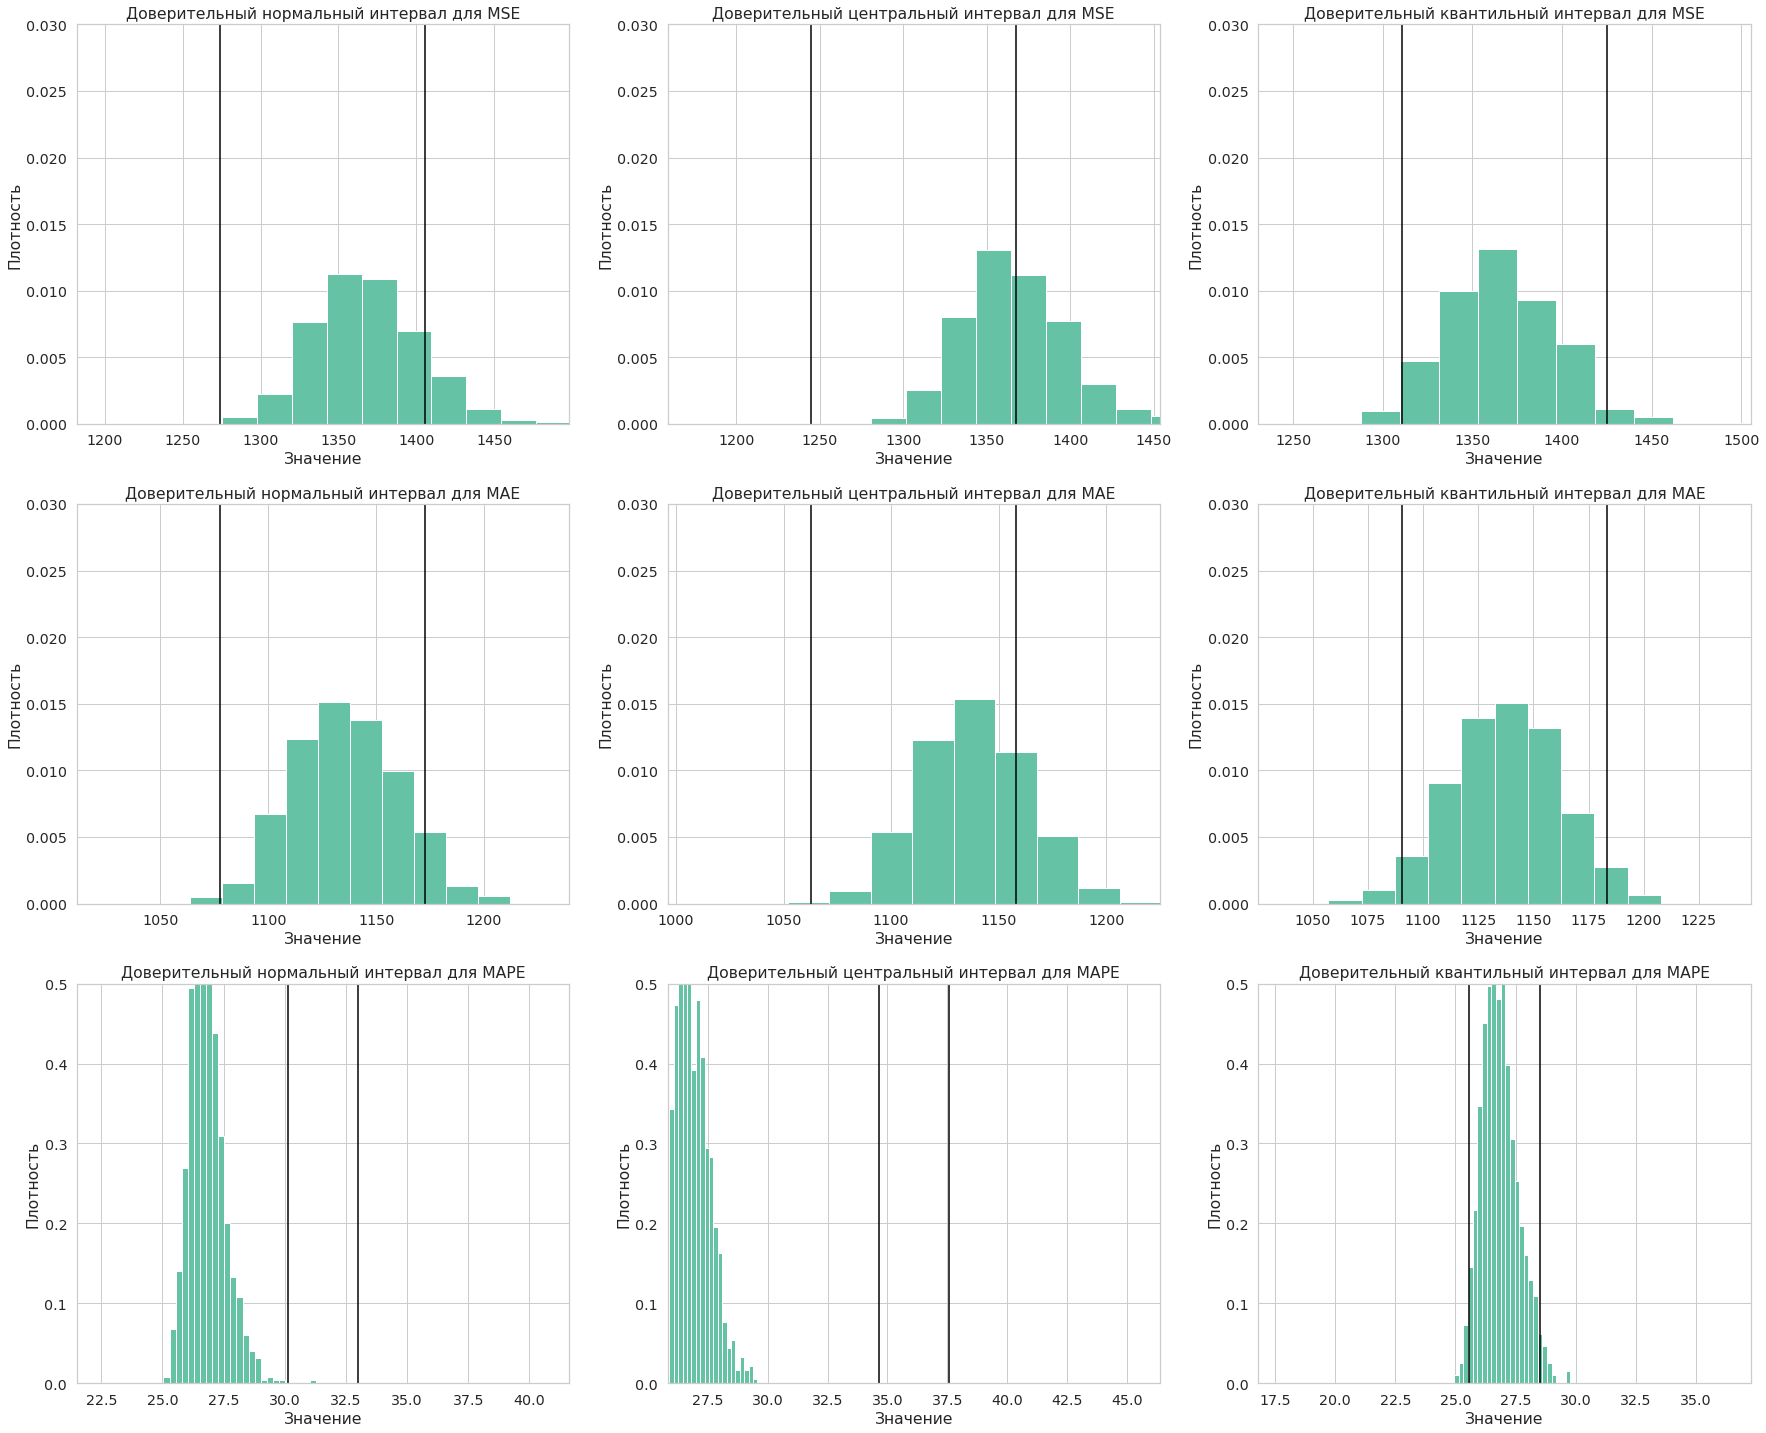

In [119]:
errors = [metrics.mean_squared_error, metrics.mean_absolute_error, mean_absolute_percentage_error]
errors_names = ["MSE", "MAE", "MAPE"]
interval_type = ['norm', 'central', 'quantile']
interval_type_names = ['нормальный', 'центральный', 'квантильный']
estims = list(count_errors(model, X_test, Y_test))

fig, axs = plt.subplots(3, 3, figsize=(30, 25))

for i in range(3):
    for j in range(3):
        errs = bootstrap_error(X_train, Y_train, X_test, Y_test, errors[i])
        if i == 0:
            errs = np.sqrt(errs)
        interval = build_interval(errs, estims[i], interval_type[j])

        ax = axs[i][j]
        bins = 10
        if i == 2:
            bins = 25
        ax.hist(errs, density=True, bins=bins)
        ax.vlines(interval[0], 0, 1)
        ax.vlines(interval[1], 0, 1)

        delta = interval[1] - interval[0]
        if i == 2:
            ax.set_ylim(0., 0.5)
            ax.set_xlim(interval[0] - delta * 3, interval[1] + delta * 3)
        else:
            ax.set_ylim(0., 0.03)
            ax.set_xlim(interval[0] - delta * 0.7, interval[1] + delta * 0.7)

        ax.set_xlabel("Значение")
        ax.set_ylabel("Плотность")
        ax.set_title(f"Доверительный {interval_type_names[j]} интервал для {errors_names[i]}")

$\alpha$ сейчас значит немного другое (уровень значимости, а не доверия), поэтому может казаться, что интервалы не совпадают с теоретическими, но все верно

**Вывод:** получили достаточно хорошо совпадающий с гистограмой дов интервал кроме, разумеется, случая с MAPE

Вероятно, такой смещенный интервал получился из-за случайной природы бутстрепной выборки, однако, это все еще выглядит немного странно

___
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики 

$$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Обоснуйте, почему при вашей реализации подсчета статистики полученное значение будет **точным**.

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле?


Для выполнения задания можно использовать следующую функцию:

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
# help(ECDF)  # В случае затруднений раскомментировать и выполнить

Эмпирическое распределение имееn $n$ неустранимых разрыва, при этом между этими разрывами функция константа. При этом реальная функция распределения строго возрастает

А значит после резкого скачка ecdf $|\hat F_n - F|$ вновь убывает. Как следствие, нет смысла проверять всю ось на максимум $sup|\hat F_n - F|$, можно проверить только эти точки разрыва

In [12]:
n_max = 10000
sample = sps.norm.rvs(size=n_max)

Dn = np.empty(shape=n_max)
Dnn = np.empty(shape=n_max)
for n in tqdm(range(1, n_max+1)):
    ecdf = ECDF(x=sample[:n])
    Dnn[n - 1] = np.abs(ecdf(sample[:n]) - sps.norm().cdf(x=sample[:n])).max()
    Dn[n - 1] = max(Dnn[n - 1], np.abs(ecdf(sample[:n]) - (1 / n) - sps.norm().cdf(x=sample[:n])).max())

100%|██████████| 10000/10000 [00:41<00:00, 241.35it/s]


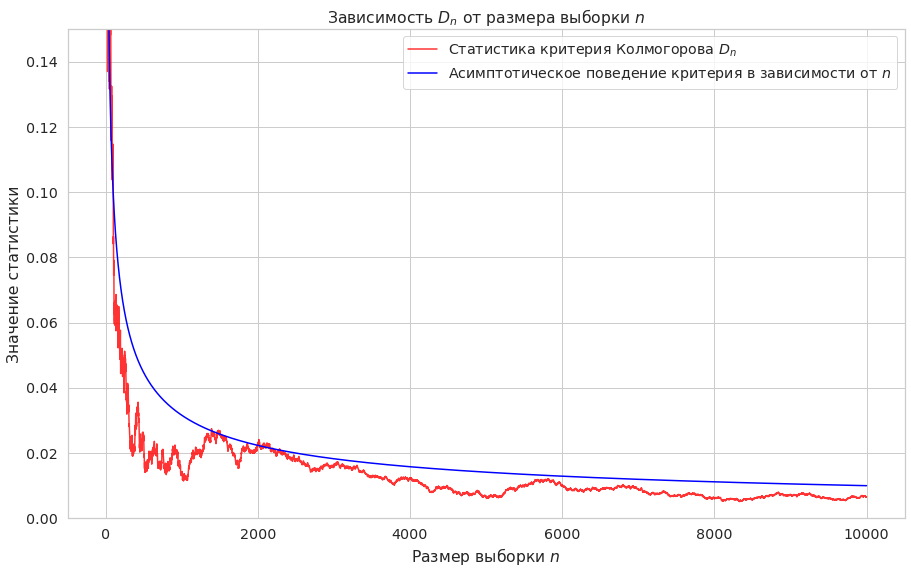

In [17]:
plt.figure(figsize=(15, 9))

ns = np.arange(1, 10001)
plt.plot(ns, Dn, color='r', alpha=0.8, label="Статистика критерия Колмогорова $D_n$")
plt.plot(ns, 1 / np.sqrt(ns), color='b', label="Асимптотическое поведение критерия в зависимости от $n$")

plt.ylim(0, 0.15)
plt.title('Зависимость $D_n$ от размера выборки $n$')
plt.xlabel('Размер выборки $n$')
plt.ylabel('Значение статистики')
plt.legend()
plt.show()

**Вывод:** в результате рассмотрели поведение статистики критерия Колмогорова-Смирнова, научились строить эмпирическую функция распределения в пару шагов

Кроме того, можно увидеть, как теоретическое представление о порядке сходимости ecdf к cdf реализовались на практике

___
### Задача 3.

Студенты периодически отправляют запросы в бот. Иногда бот бывает недоступен,
поэтому студенты с некоторыми интервалами повторяют запросы до тех пор, пока
бот не ответит. Известно, что $52$ запроса дошли с первой попытки, $31$ &mdash; со второй, $3$
&mdash; с третьей, а для доставки еще $5$ запросов потребовалось более $4$ попыток. Верно
ли, что бот получает запросы с вероятностью $\frac{2}{3}$?

**Решение:**

Исходя из предоположения, имеем дело с $\mathit{Geom}(\theta)$, причем 

* $\mu = (52, 31, 3, 5)$
* $p_i^0 = (\dfrac{2}{3}, \dfrac{2}{9}, \dfrac{2}{27}, \dfrac{1}{27})$
* $B_i = \{i\}$, кроме $B_4 =\{4, 5, 6 \dots\}$

Тогда:

In [ ]:
mus = np.array([52, 31, 3, 5])

ps = (1/3) ** np.arange(mus.size - 1) * 2/3
ps = np.append(ps, [1 - ps.sum()])

n = mus.sum()

chi = ((mus - n * ps)**2 / (n * ps)).sum()
chi, sps.chi2.sf(df=(ps.size - 1), x=chi)

(9.846153846153841, 0.019920187998572737)

Проверим, что условия использования данного критерия выполняются

In [ ]:
n > 50, n * ps >= 5

(True, array([ True,  True,  True, False]))

Атата, не выполняются условия. Попробуем еще раз

* $\mu = (52, 31, 8)$
* $p_i^0 = (\dfrac{2}{3}, \dfrac{2}{9}, \dfrac{1}{9})$
* $B_1 = \{1\}$, $B_2 = \{2\}$, $B_3 =\{3, 4, 5, 6 \dots\}$

Тогда:

In [ ]:
mus = np.array([52, 31, 8])

ps = (1/3) ** np.arange(mus.size - 1) * 2/3
ps = np.append(ps, [1 - ps.sum()])

n = mus.sum()

chi = ((mus - n * ps)**2 / (n * ps)).sum()
p_value = sps.chi2.sf(df=(ps.size - 1), x=chi)
chi, p_value, p_value < alpha

(7.423076923076925, 0.02443989449617617, True)

In [ ]:
n > 50, n * ps >= 5

(True, array([ True,  True,  True]))

**Вывод:** получили, что p-value $ \sim 0.024 < 0.05 \implies$ гипотеза о том, что это геометрическое распределение отвергается. Видимо, с ботом все куда интереснее, чем кажется на первый взгляд

Кроме того, нужно быть аккуратнее с применением критерия $\chi$-квадрат, так как видим, что после корректного его применения p-value **увеличилось**, следовательно, в каком-то другом случае это может изменить ответ в результате проверки гипотезы

____
### Задача 4.

С помощью критерия хи-квадрат вам нужно проверить, правильно ли `scipy.stats` генерирует случайные величины. 

**1.** Реализуйте критерий для генерации выборки $U\{1, ..., 10\}$, аналогично разобранному на семинаре. Тем самым проверьте, что `sps.randint` действительно генерирует выборку из равномерного распределения.


**Важно**: чтобы проверить корректность, будет проверять не только то, что значения близко к к ожидаемым плотностям, но и то, что они не слишком близко, т.е. что это все-таки случайная величина, а не какая-то хитрая подгонка

Для этого критерий будет иметь вид $S = \{\chi(X) \gt \chi_{k - 1, 1 - \frac{\alpha}{2}}^2\} \bigcup \{\chi(X) \lt \chi_{k - 1, \frac{\alpha}{2}}^2\}$

In [ ]:
n = 10000  # берем такое для заведомого выполнения условий применения критерия
k = 10
sample = sps.randint(low=1, high=(k+1)).rvs(size=n)

values, mus = np.unique(sample, return_counts=True)
nps = n / k

chi = ((mus - nps)**2 / nps).sum()
p_value = min(sps.chi2(df=(k-1)).sf(chi), sps.chi2(df=(k-1)).cdf(chi))
p_value, p_value < alpha

(0.38881745216935154, False)

**2.** Проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

**Указания**
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код в отдельной ячейке для *конкретной* реализации выборки. Так вам проще реализовать, а нам проще проверять.
**Решение:**

Значений у нас здесь бесконечное число, поэтому нужно правильно разбить множество yf $B_j$, чтобы $np_j^0 \ge 5$

In [ ]:
n = 1000
distr = sps.poisson(mu=5)

k = 10 # при 13 последняя штука меньше 5
ps = np.append(distr.pmf(np.arange(k)), [distr.sf(k-1/2)])
ps

array([0.00673795, 0.03368973, 0.08422434, 0.1403739 , 0.17546737,
       0.17546737, 0.14622281, 0.10444486, 0.06527804, 0.03626558,
       0.03182806])

In [ ]:
sample = distr.rvs(size=n)

In [ ]:
values, mus = np.unique(sample, return_counts=True)
mus = np.append(mus[:k], mus[k:].sum())

chi = ((mus - n * ps)**2 / (n * ps)).sum()
p_value = min(sps.chi2(df=(ps.size-1)).sf(chi), sps.chi2(df=(ps.size-1)).cdf(chi))
p_value, p_value < alpha

(0.4541889392117471, False)

**Вывод:**

В обоих случаях гипотеза не отвергается, т.е. нельзя сказать про некорректность работы генератора. Возможно, критерий недостаточно мощный, а может быть гипотеза все-таки верна

__________________
### Задача 5.

На лекциях и семинарах были разобраны следующие критерии проверки нормальности:
* Колмогорова;
* Жарка-Бера;
* Шапиро-Уилка.

Cуществует модификация критерия Колмогорова для проверки нормальности — <a href="https://ru.wikipedia.org/wiki/Критерий_Лиллиефорса"> Критерий Лиллиефорса.</a> При решении задачи можете воспользоваться им, например, взяв реализацию из библиотеки `statsmodels`: <a href="https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.lilliefors.html">`statsmodels.stats.diagnostic.lilliefors`</a>, или же применять для конкретной $F_0$ критерий Колмогорова, пример использования которого можно найти в ноутбуке с лекции.

**1.** Данные критерии являются асимптотическими, и их реальное значение уровня значимости может отличаться от желаемого числа $\alpha=0.05$. На семинарах разобран метод оценки реального уровня значимости критерия. Посчитайте реальный уровень значимости этих критериев для размеров выборки от 5 до 100.

*Подсказка:*

In [ ]:
max_sample_size = 100
sample_count = 1000
is_reject_lilliefors = np.zeros((max_sample_size, sample_count))

for i in tqdm(range(max_sample_size)):
    for j in range(sample_count):
        sample = ...
        is_reject_<критерий>[i, j] = ...

Ваша реализация:

In [ ]:
max_sample_size = 100
min_sample_size = 5
sample_count = 10000

is_reject_lilliefors = np.zeros((max_sample_size + 1 - min_sample_size, sample_count))
is_reject_jarq_bera = np.zeros((max_sample_size + 1 - min_sample_size, sample_count))
is_reject_shap_wilk = np.zeros((max_sample_size + 1 - min_sample_size, sample_count))

sample = sps.norm.rvs(size=(sample_count, max_sample_size))
for i in tqdm(range(min_sample_size, max_sample_size + 1)):
    for j in range(sample_count):
        is_reject_lilliefors[i- min_sample_size, j] = lilliefors(sample[j, :i])[1] < alpha
        is_reject_jarq_bera[i - min_sample_size, j] = sps.jarque_bera(sample[j, :i])[1] < alpha
        is_reject_shap_wilk[i - min_sample_size, j] = sps.shapiro(sample[j, :i])[1] < alpha

100%|██████████| 96/96 [01:01<00:00,  1.57it/s]


In [ ]:
real_lilliefors = is_reject_lilliefors.mean(axis=1)
real_jar_bera = is_reject_jarq_bera.mean(axis=1)
real_shap_wilk = is_reject_shap_wilk.mean(axis=1)

In [ ]:
real_shap_wilk.shape

(96,)

Поясните, почему вы выбрали такое значение `sample_count`.

Знаем, что точность порядка $\dfrac{1}{\sqrt{n}}$, поэтому чтобы было хотя бы 2 знака) (как у $\alpha = 0.05 $ берем такое 

Нарисуйте на одном графике зависимость реального уровня значимости от размера выборки для каждого критерия. Пунктиром отметьте уровень 0.05. Не забудьте добавить легенду и подписать оси.

In [ ]:
<...>

Какой можно сделать вывод?

<...>

**2.** Аналогичным образом можно вычислять мощность критерия. Вычислите мощности критериев для размеров выборки от 5 до 100, если альтернативная гипотеза заключается в том, что выборка имеет стандартное распределение Коши. Иначе говоря, для критерия $S$ надо приближенно посчитать $\beta_S(\mathsf{P})$, где $\mathsf{P}$ — стандартное распределение Коши.

Нарисуйте на одном графике зависимость мощности критерия от размера выборки для каждого критерия. Не забудьте добавить легенду и подписать оси.


In [ ]:
<...>

Сделайте вывод. Какой критерий является наиболее мощным при данной альтернативе?

<...>

**3.** Распределение Стьюдента является в некотором смысле обобщением нормального распределения (при бесконечном количестве степеней свободы) и распределения Коши (при одной степени свободы). 
Посчитайте приближенно мощности критериев для выборки размера 50 если альтернатива заключается в том, что выборка имеет распределение Стьюдента. Поскольку мощность критерия является функцией от распределения из альтернативной гипотезы, вам нужно посчитать функцию. Посчитайте её значения для целых значений степени свободы от 1 до 10.

Нарисуйте на одном графике зависимость мощности критерия от количества степеней свободы для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [ ]:
<...>

Сделайте вывод относительно мощности критерия при разных распределениях из альтернативы.

<...>

**4.** Аналогичным образом посчитайте мощности критериев, если альтернативная гипотеза заключается в том, что выборка имеет экспоненциальное распределение. Постройте график зависимости мощности от параметра альтернативной гипотезы.

In [ ]:
<...>

Сделайте вывод:

<...>

___________
### Задача 6.

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`. В дальнейшем будем называть колонки признаками.

In [18]:
columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
           'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
           'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', sep=',', header=None)
wine.columns = columns
wine.drop(labels=['Class'], axis=1, inplace=True)
wine.sample(7)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
136,12.25,4.72,2.54,21.0,89,1.38,0.47,0.53,0.80,3.85,0.75,1.27,720
101,12.60,1.34,1.90,18.5,88,1.45,1.36,0.29,1.35,2.45,1.04,2.77,562
18,14.19,1.59,2.48,16.5,108,3.30,3.93,0.32,1.86,8.70,1.23,2.82,1680
144,12.25,3.88,2.20,18.5,112,1.38,0.78,0.29,1.14,8.21,0.65,2.00,855
26,13.39,1.77,2.62,16.1,93,2.85,2.94,0.34,1.45,4.80,0.92,3.22,1195
96,11.81,2.12,2.74,21.5,134,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [19]:
len(columns) - 1

13

Для каждого из признаков нарисуйте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

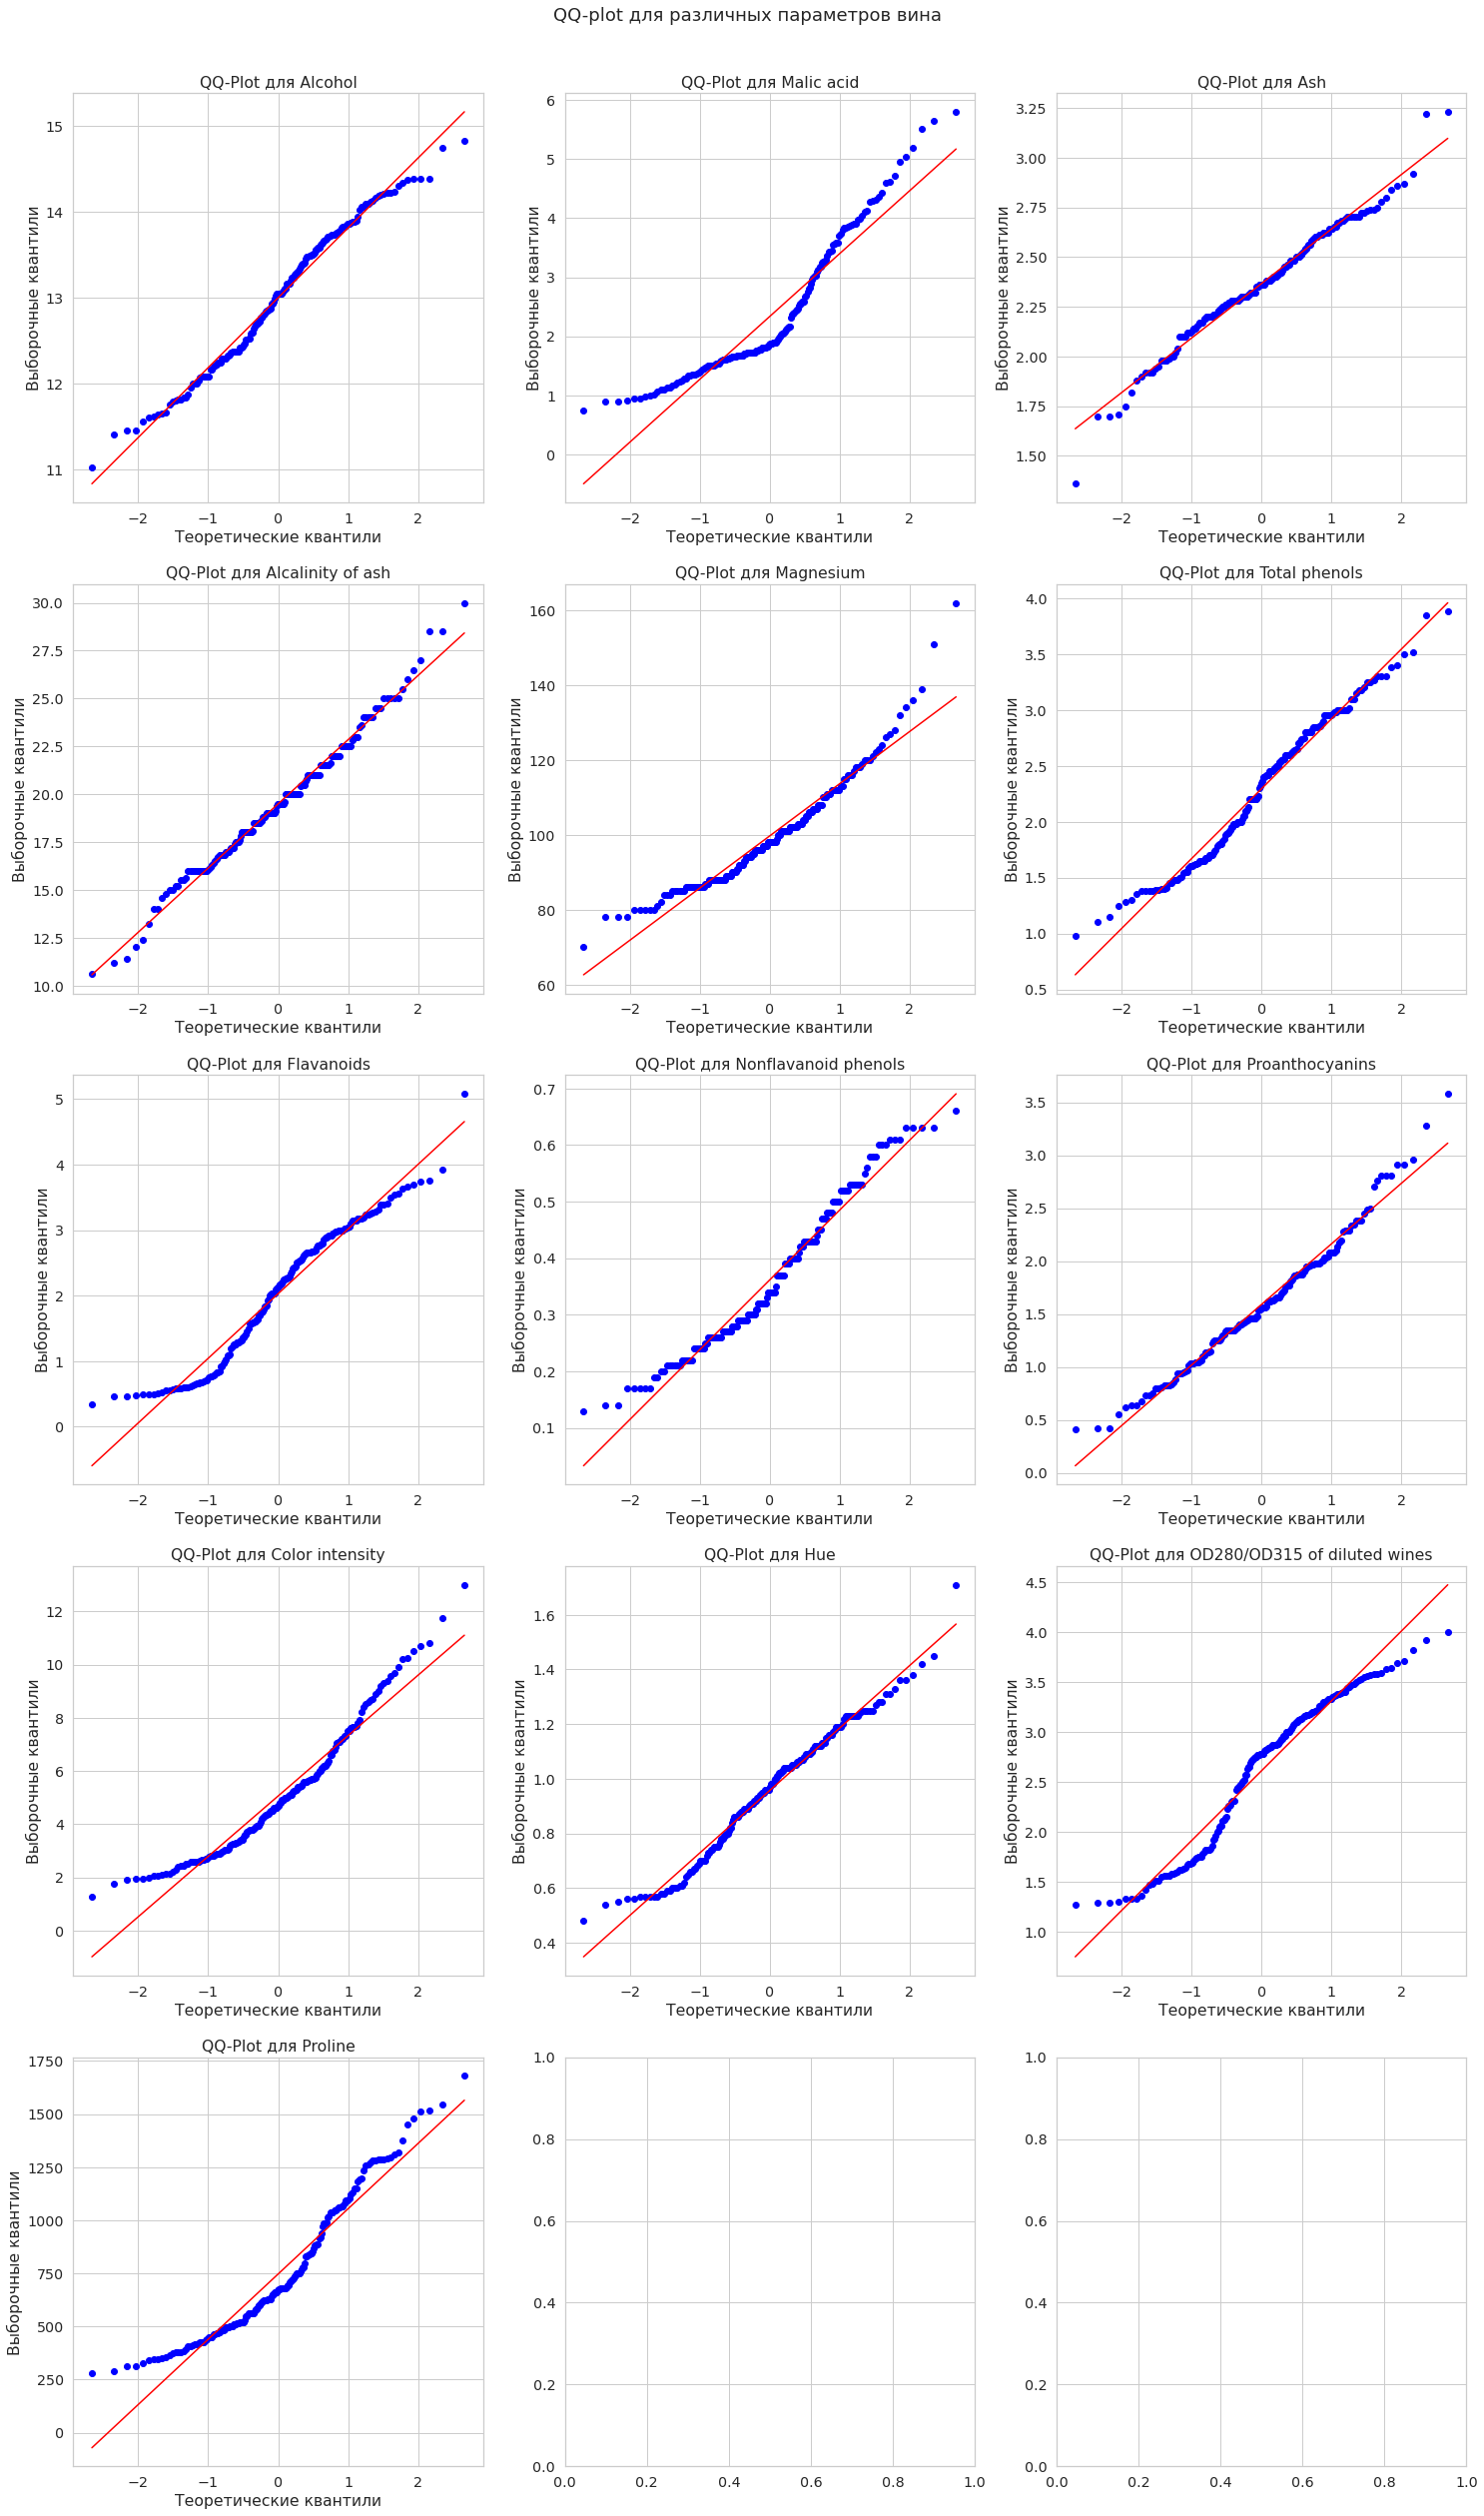

In [20]:
fig, axs = plt.subplots(5, 3, figsize=(25, 40))

for ax, column in zip(axs.flatten(), wine.columns):
    sps.probplot(wine[column], plot=ax)
    ax.set_title("QQ-Plot для " + column)
    ax.set_xlabel('Теоретические квантили')
    ax.set_ylabel('Выборочные квантили')

fig.subplots_adjust(top=0.95)
fig.suptitle("QQ-plot для различных параметров вина", fontsize=18)
fig.show()

Для каких признаков можно говорить об их нормальности и почему?

**Ответ:** 

Для параметров Ash, Alcanity of Ash, Proanthocyanins. Случай Total phenols и Hue тоже похож на прямую, но чуть меньше. В остальных случаях график не так сильно похож на прямую. 

Проверьте нормальность каждого признака статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы. Помочь в этом может теоретическое домашнее задание 10.

Для каждого признака используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:**

В начале можно посмотреть Jarque-Bera, потом Shapiro–Wilk - второй на практике более мощный, но нет смысла проверять на втором, если первый уже отвергнет гипотезу о нормальности выборки

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех признаков и всех критериев сразу. Почему так нужно делать?

**Ответ:** 

Потому что, как уже было показано на лекции и домашках, без этого вероятность того, что мы отвергнем хотя бы одну верную гипотезу, может быть порядка $k \alpha$, где $k$ - число гипотез, тем более в случае с независимыми величинами. Поэтому, чтобы контролировать общую ошибку (FWER) на требуемом уровне, нужно делать эту поправку

Какой метод для контроля FWER стоит применить и почему?

**Ответ:**

Мы ничего не знаем про зависимости между этими параметрами, поэтому пользоваться методом Шидака или Шидака-Холма не можем (а они требуют независимости между выборками).

Остаются только Бонферрони и Холм, но Холм равномерно более мощный чем Бонферрони, поэтому берем его

По хорошему, можно было бы в начале вообще проверить FDR, проконтролировать его на уровне, например, 0.1, и только после этого проверять FWER, что более дорогостоящее мероприятие

Как понять из результата процедуры множественной проверки гипотез, нормальность каких признаков следует отклонить?

**Ответ:** 

Ровно те, которые отклоним в результате множественной проверки гипотез хотя бы одним из критериев (желательно, самым мощным)

Если нормальность не отклоняется, что можно сказать про выборку? Ответ находится в презентации с лекции.

**Ответ:**

Как и всегда при проверке гипотез, ничего не можем сказать. Имеет смысл провести еще одну проверку, чтобы быть более увереными, но не отвергается != принимается, не смотря даже на то, что это критерии **согласия**

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результаты соберите обратно в таблицу с помощью метода `reshape`, которому необходимо передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия признаков, а названий столбцов — используемые критерии. В таблице должны присутстововать как значения p-value, так и результат проверки (`True` в случае отвержения).

In [23]:
def perform_test(df, rows, criteria, method='holm'):
    result = pd.DataFrame(
        columns = pd.MultiIndex.from_product([criteria.keys(), ['p-value', 'corrected p-value', 'Отвергаем?']], names=['Критерий', 'Результат проверки']),
        index = rows)
    for criterion in criteria.keys():
        for row in rows:
            result.loc[row, (criterion, 'p-value')] = criteria[criterion](df[row])[1]
    
    fwer_columns = zip(criteria.keys(), ['p-value'] * 2)
    shp = result.iloc[:, result.columns.get_level_values(1)=='p-value'].to_numpy().shape
    
    test = multipletests(result.iloc[:, result.columns.get_level_values(1)=='p-value'].to_numpy().ravel(), method=method, alpha=alpha)
    
    result.loc[:, result.columns.get_level_values(1)=='corrected p-value'] = test[1].reshape(shp)
    result.loc[:, result.columns.get_level_values(1)=='Отвергаем?'] = test[0].astype(int).reshape(shp)
    
    return result

Добавим все признаки, чтобы убедиться, что мы не ошиблись, глядя на QQ-plot

In [25]:
test_columns = columns[1:]

# хочется еще Anderson-Darling
result = perform_test(wine, test_columns,
                      {'Jarque-Bera': sps.jarque_bera, 'Lilliefors':lilliefors, 'Shapiro-Wilk': sps.shapiro, "D\'Agostino": sps.normaltest})

def highlight_reject(val):
    color = '#ffff00' if val == 1 and type(val) == np.int else '#ffffff'
    return f'background-color: {color};'

display(result.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
    'border': '1px black solid !important'
}).set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px black solid !important')]
}]).applymap(highlight_reject))

**Ответ:** 

Из тех признаков, которые, казалось, обладали нормальным распределением, был отвергнут Total phenols на последнем критерии D'Agostino. Остальные прошли проверки, а из невыбранных методом "пристального взгляда на QQ-plot" признаков ни один не прошел все проверки (ломался на 2 или всех 4 критериях)

**Вывод:** 

Как видим, первые несколько проверок Total phenols прошел, а вот последнюю уже нет, хотя на этот параметр я возлагал больше надежд, чем на Hue. Таким образом, отвергли гипотезу, что распределение параметра Total phenols нормальное. С другой стороны, про другие параметры мы не можем сказать, распределены ли они нормально или нет, так как ни один из представленных критериев их не отверг, что вообще говоря, при таком количестве различных критериев, должно давать уверенность в том, что эти остальные параметры действительно распределены нормально